In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX


逻辑回归(Logistic Regression), 是使用回归的实现的分类算法，只能解决二分类问题. 在Kaggle竞赛中，LR算法以63.5，荣获"出场率最高算法"

$$
\hat{p}=f(x) \quad \hat{y}=\left\{\begin{array}{ll}
1, & \hat{p} \geq 0.5 \\
0, & \hat{p} \leq 0.5
\end{array}\right.
$$

假定f(x)为一个线性回归问题，他的值域(-infinity,+infinity)

$$
f(x)= x_{b} \cdot \theta
$$

使用Sigmoid函数限定为概率的值域`[0,1]`

$$
\sigma(t)=\frac{1}{1+e^{-t}}
$$


## Sigmoid函数


$$
\sigma(t)=\frac{1}{1+e^{-t}}
$$

值域(0,1)

- t0时候, p=0.5
- t>0时候, p>0.5
- t<0时候, p<0.5

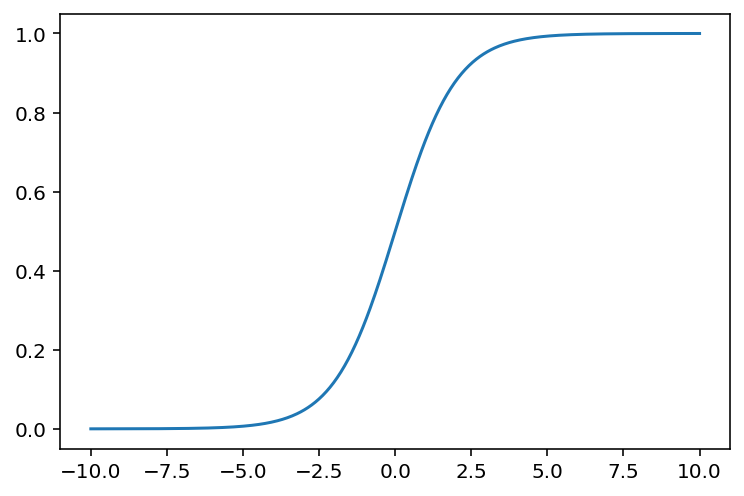

In [2]:
# 返回e的幂次方，e是一个常数为2.71828。将线性方程转化为0-1之间的概率。
def sigmoid(t):
    return 1.0 / (1+np.exp(-t))

x = np.linspace(-10, 10, 500)
plt.plot(x, sigmoid(x))
plt.show()

## 实现逻辑回归

**逻辑回归的模型**

$$
\hat{p}=\sigma\left(f(x)\right)=\sigma\left(x_{b} \cdot {\theta}\right)=\frac{1}{1+e^{x_{b} \cdot {\theta}}}
$$


$$
\hat{y}=\left\{\begin{array}{ll}
1, & \hat{p} \geq 0.5 \\
0, & \hat{p} \leq 0.5
\end{array}\right.
$$

问题: 给定的样本集X,y, 如何找到对应的参数Theta(使用梯度下降搜索),是的最大程度获得样本数据集X对应的分类输出y? 

解决方法: 最小话损失函数，使用梯度下降找到对应的Theta

**假设损失函数**
从逻辑回归的模型可看出

- 当y=1时, p值越小，损失越大；p值越大，损失越小。
- 当y=0时, p值越小，损失越小；p值越大，损失越大。

用一下函数来模拟这个现象:

![](https://cdn.mathpix.com/snip/images/qTmDAcJcnync8BvCYSpr77Bq8IjGYhJfiRkQprQQ9oA.original.fullsize.png)

进一步推导:

$$
\operatorname{cost}=-y \log (\hat{p})-(1-y) \log (1-\hat{p})
$$

=>

$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log \left(\hat{p}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{p}^{(i)}\right)
$$

=>

$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log \left(\sigma\left(X_{b}^{(i)} \theta\right)\right)+\left(1-y^{(i)}\right) \log \left(1-\sigma\left(X_{b}^{(i)} \theta\right)\right)
$$

$$
\nabla J(\theta)=\frac{1}{m} \cdot\left(\begin{array}{c}
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{1}^{(i)} \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{2}^{(i)} \\
\cdots \\
\sum_{i=1}^{m}\left(\hat{y}^{(i)}-y^{(i)}\right) \cdot X_{n}^{(i)} \\
\end{array}\right)
=\frac{1}{m} \cdot X_{b}^{T} \cdot\left(\sigma\left(X_{b} \theta\right)-y\right)
$$

以上方程无公式解, 只能使用梯度下降法求解

In [3]:
import numpy as np


class LogisticRegression:
    def __init__(self):
        self._thetas = None
        # 截距
        self.intercept = None
        # 参数系数
        self.coefs = None

    @staticmethod
    def sigmoid(t):
        return 1.0 / (1 + np.exp(-t))

    def j(self, x, y, theta):
        """目标函数"""
        try:
            sig = self.sigmoid(x.dot(theta))
            return -(np.sum(y.dot(np.log(sig)) + (1-y).dot(1-sig))) / len(x)
        except:
            # 当数据特别大，报错时，返回无穷大。
            return float('inf')

    def dj_debug(self, x, y, theta, epsilon=0.01):
        """梯度调试"""
        res = np.empty(len(theta))
        for i in range(len(theta)):
            theta_1 = theta.copy()
            theta_1[i] += epsilon
            theta_2 = theta.copy()
            theta_2[i] -= epsilon
            res[i] = (self.j(theta_1, x, y) - self.j(theta_2, x, y)) / (2 * epsilon)
        return res

    def dj(self, x, y, thetas):
        """求导(梯度)"""
        sig = self.sigmoid(x.dot(thetas))
        return (x.T).dot(sig-y)

    def gradient_descent(self, dj, x, y, initial_thetas, eta, epsilon, max_iters):
        """梯度下降"""
        thetas = initial_thetas
        while max_iters > 0:
            # 梯度gradient
            gradient = dj(x, y, thetas)
            last_thetas = thetas
            thetas = thetas - eta * gradient
            if(abs(self.j(x, y, thetas) - self.j(x, y, last_thetas)) < epsilon):
                break
            max_iters -= 1

        self._thetas = thetas
        self.intercept = thetas[0]
        self.coefs = thetas[1:]

    def fit(self, x_train, y_train, eta=0.01, epsilon=1e-8, max_iters=1e4, debug=False):
        """训练"""
        # 加上一列全为1
        X_b = np.hstack([np.ones((len(x_train), 1)), x_train])
        initial_thetas = np.zeros(X_b.shape[1])

        if debug:
            self.gradient_descent(self.dj_debug, X_b, y_train, initial_thetas, eta, epsilon, max_iters)
        else:
            self.gradient_descent(self.dj, X_b, y_train, initial_thetas, eta, epsilon, max_iters)

    def predict(self, x_predict):
        X_b = np.hstack([np.ones((len(x_predict), 1)), x_predict])
        p = self.sigmoid(X_b.dot(self._thetas))
        p[p >= 0.5] = 1
        p[p < 0.5] = 0

        return p

    def score(self, x, y):
        """accuracy=正确的数据量 / 样本量"""
        y_predict = self.predict(x)
        return np.sum(y == y_predict) / len(y)

In [4]:
from sklearn import datasets

# 只使用两种莺尾花和两个特征
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = X[y < 2, : 2]
y = y[y < 2]

# 训练模型
log_reg = LogisticRegression()
log_reg.fit(X, y)
print('coefs: ', log_reg.coefs)
print('intercept: ', log_reg.intercept)
print('Score: ', log_reg.score(X, y))

coefs:  [  9.91317105 -11.51345535]
intercept:  -17.935266908864193
Score:  0.99


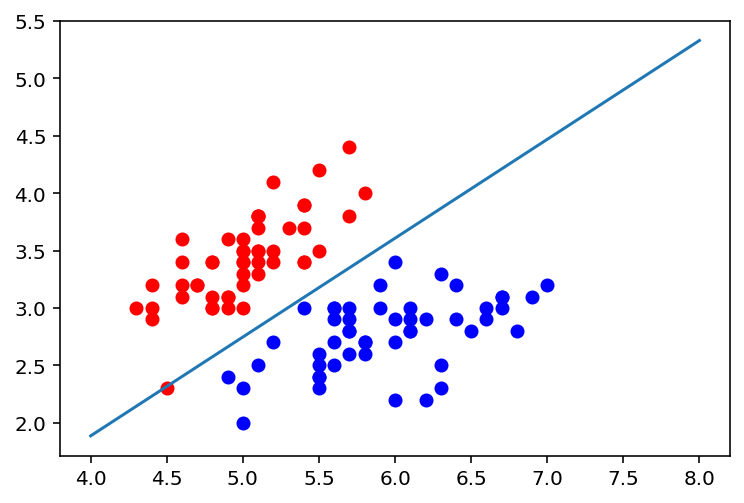

In [5]:
plt.scatter(X[y==0,0], X[y==0,1], color="red")
plt.scatter(X[y==1,0], X[y==1,1], color="blue")

# 绘制分隔线
# x1 = np.arange(4, 8, 0.01)
x1 = np.linspace(4, 8, 1000)
y1 = x1 * (log_reg.coefs[0]/(-log_reg.coefs[1])) + (log_reg.intercept/-log_reg.coefs[1])
plt.plot(x1, y1)
plt.show()

## 决策边界绘制

In [6]:
def plot_decision_boundary(model, axis):
    """ 决策边界绘制函数(2D)
    """
    # x轴: axis[0]~axis[1]; y轴: axis[0]~axis[1]
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)
    

### 两类莺尾花决策边界绘制(两个特征)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


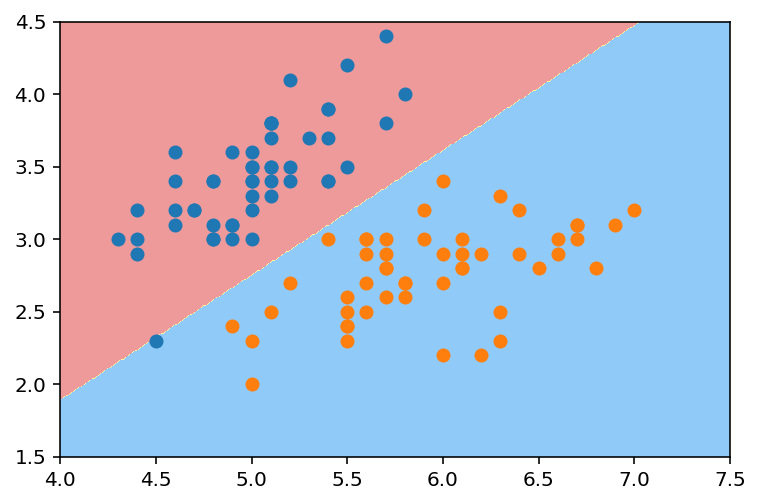

In [7]:
plot_decision_boundary(log_reg, axis=[4, 7.5, 1.5, 4.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 三类莺尾花决策边界绘制(两个特征)

Score:  0.84


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


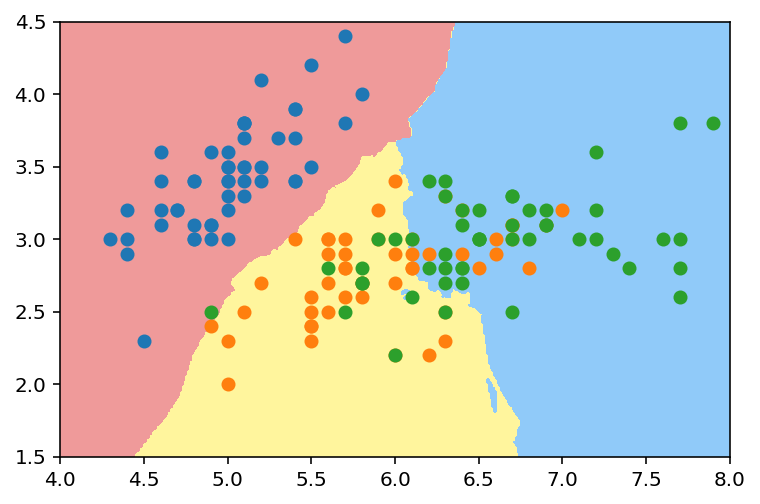

In [8]:
# 全部类别的莺尾花(两个特征)，因为有三类，而逻辑回归只能解决二分类问题，所以使用knn解决
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

# 只使用两种莺尾花和两个特征
iris = datasets.load_iris()
X_all = (iris.data)[:,:2]
y_all = iris.target
# 调整n_neighbors, 控制拟合度
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_all, y_all)
print('Score: ', knn.score(X_all, y_all))

# 绘制预测值和决策边界
plot_decision_boundary(knn, axis=[4, 8, 1.5, 4.5])
plt.scatter(X_all[y_all==0,0], X_all[y_all==0,1])
plt.scatter(X_all[y_all==1,0], X_all[y_all==1,1])
plt.scatter(X_all[y_all==2,0], X_all[y_all==2,1])
plt.show()

## 逻辑回归中添加多项式特征

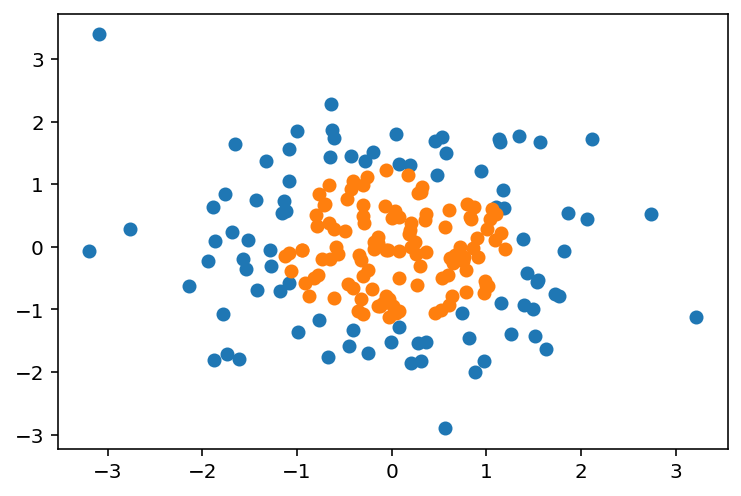

In [9]:
np.random.seed(666)
X = np.random.normal(0, 1, size=(200, 2))
y = np.array((X[:,0]**2+X[:,1]**2)<1.5, dtype='int')

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 单纯使用逻辑回归

如下，因为现实中边界类似于圆, 而逻辑回归得到的边界是条直线，拟合很差。从而使得分比较低。

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)
print('Score', log_reg.score(X, y))

Score 0.605


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


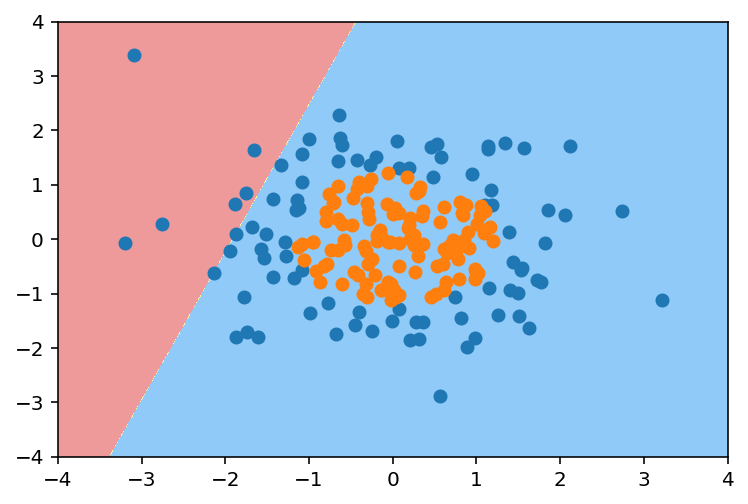

In [11]:
# 绘制预测值和决策边界
plot_decision_boundary(log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 加入多项式特性

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def PolynomialLogisticRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('log_reg', LogisticRegression())
    ])


poly_log_reg = PolynomialLogisticRegression(degree=2)
poly_log_reg.fit(X, y)
print('score: ', poly_log_reg.score(X, y))

score:  0.975


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


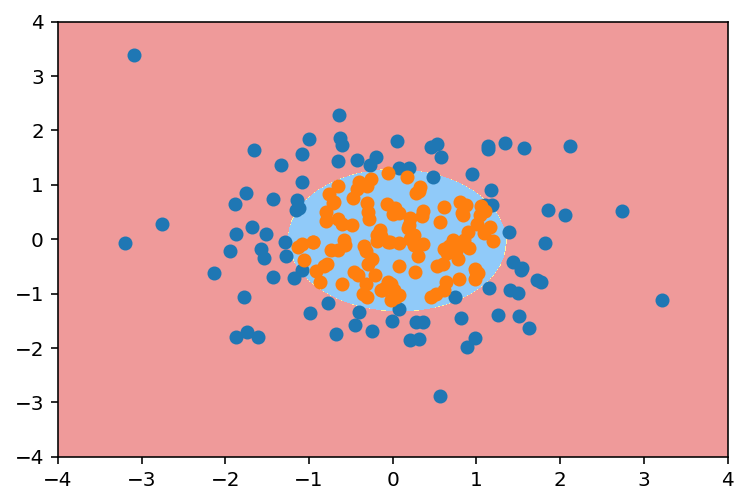

In [13]:
plot_decision_boundary(poly_log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

## 多分类问题

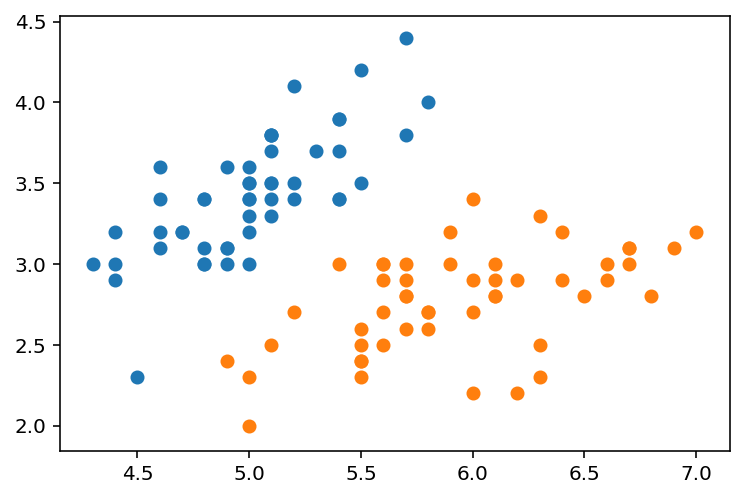

In [14]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

log_reg = LogisticRegression()

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()


### OVR

In [15]:
from sklearn.multiclass import OneVsRestClassifier


ovr = OneVsRestClassifier(log_reg)
ovr.fit(X, y )
print('Score: ', ovr.score(X, y))

Score:  0.8066666666666666


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


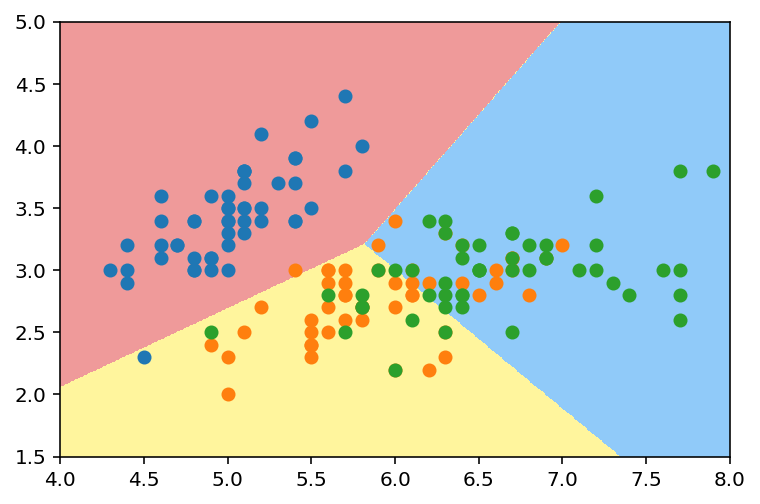

In [16]:
# 绘制预测值和决策边界
plot_decision_boundary(ovr, axis=[4, 8, 1.5, 5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

### OVO

In [17]:
from sklearn.multiclass import OneVsOneClassifier

ovo = OneVsOneClassifier(log_reg)
ovo.fit(X, y )
print('Score: ', ovo.score(X, y))

Score:  0.8333333333333334


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


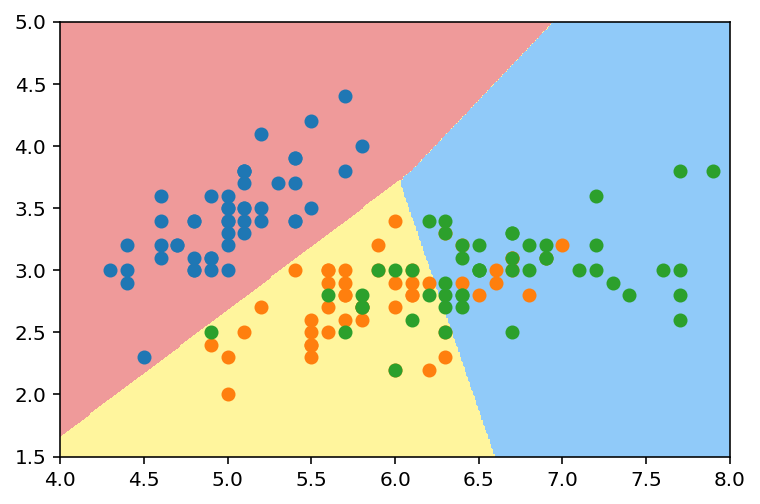

In [18]:
# 绘制预测值和决策边界
plot_decision_boundary(ovo, axis=[4, 8, 1.5, 5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()